In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the datasets
daily_data = pd.read_csv('data/AAPL_daily.csv')
sentiment_data = pd.read_csv('AAPL_monthly_sentiment2.csv')

# Rename the 'time published' column to 'Date' for easy merging
sentiment_data = sentiment_data.rename(columns={'Time Published': 'Date'})

sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'], format='%Y%m%dT%H%M%S').dt.strftime('%Y-%m-%d')

# Merge the datasets on 'Date'
merged_data = pd.merge(daily_data, sentiment_data, on='Date')

# Create volatility feature
merged_data['Volatility'] = merged_data['High'] - merged_data['Low']

# Create daily price change feature
merged_data['Daily_Change'] = merged_data['Close'] - merged_data['Open']

# Create 5-day moving average of close prices
merged_data['MA_5'] = merged_data['Close'].rolling(window=5).mean()

# Create Relative Strength Index (RSI)
window_length = 14
close = merged_data['Close']
delta = close.diff()
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0
roll_up1 = up.rolling(window_length).mean()
roll_down1 = down.abs().rolling(window_length).mean()
RS = roll_up1 / roll_down1
merged_data['RSI'] = 100.0 - (100.0 / (1.0 + RS))

# Shift the sentiment score one day forward
merged_data['Overall Sentiment Score'] = merged_data['Overall Sentiment Score'].shift(1)

# After shifting, you will have one row with NaN for the sentiment score, so drop that
merged_data = merged_data.dropna()

# Create a target variable: 1 if the stock price rose during the day, 0 otherwise
merged_data['Target'] = (merged_data['Close'] - merged_data['Open'] > 0).astype(int)

# Drop rows with NaN values (due to diff() and shift() operations)
merged_data = merged_data.dropna()

# Split the data into training and test sets
train_set, test_set = train_test_split(merged_data, test_size=0.2, random_state=42)

# Split the data into majority and minority classes
class_0 = train_set[train_set['Target'] == 0]
class_1 = train_set[train_set['Target'] == 1]

# Determine the number of samples you want from the majority class
# For a 50-50 balance, set it to the size of class_1
num_samples = len(class_1)

# Randomly downsample the majority class
downsampled_class_0 = class_0.sample(n=num_samples, random_state=42)

# Combine the downsampled majority class with the minority class
balanced_train_set = pd.concat([downsampled_class_0, class_1], axis=0)

# Shuffle the balanced dataset
balanced_train_set = balanced_train_set.sample(frac=1, random_state=42)

# Now you can proceed with your data preprocessing using the balanced_train_set DataFrame

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=500, random_state=42) 

# Extract features and labels for training and testing
X_train_rf = balanced_train_set[['Overall Sentiment Score', 'Volatility', 'Daily_Change', 'MA_5', 'RSI']]
y_train_rf = balanced_train_set['Target']

X_test_rf = test_set[['Overall Sentiment Score', 'Volatility', 'Daily_Change', 'MA_5', 'RSI']]
y_test_rf = test_set['Target']

# Train the classifier
rf_clf.fit(X_train_rf, y_train_rf)

# Predict on test data
y_pred_rf = rf_clf.predict(X_test_rf)

# Evaluate accuracy
accuracy = accuracy_score(y_test_rf, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")


ValueError: Cannot take a larger sample than population when 'replace=False'

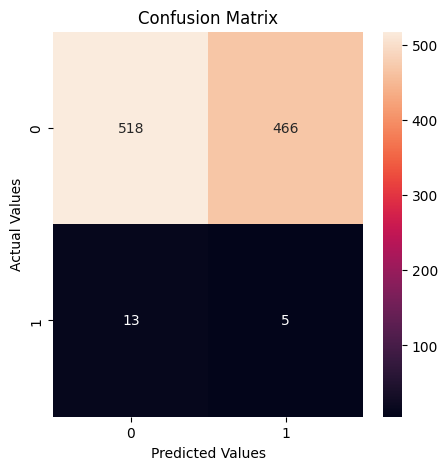

In [9]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_rf, y_pred_rf)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()



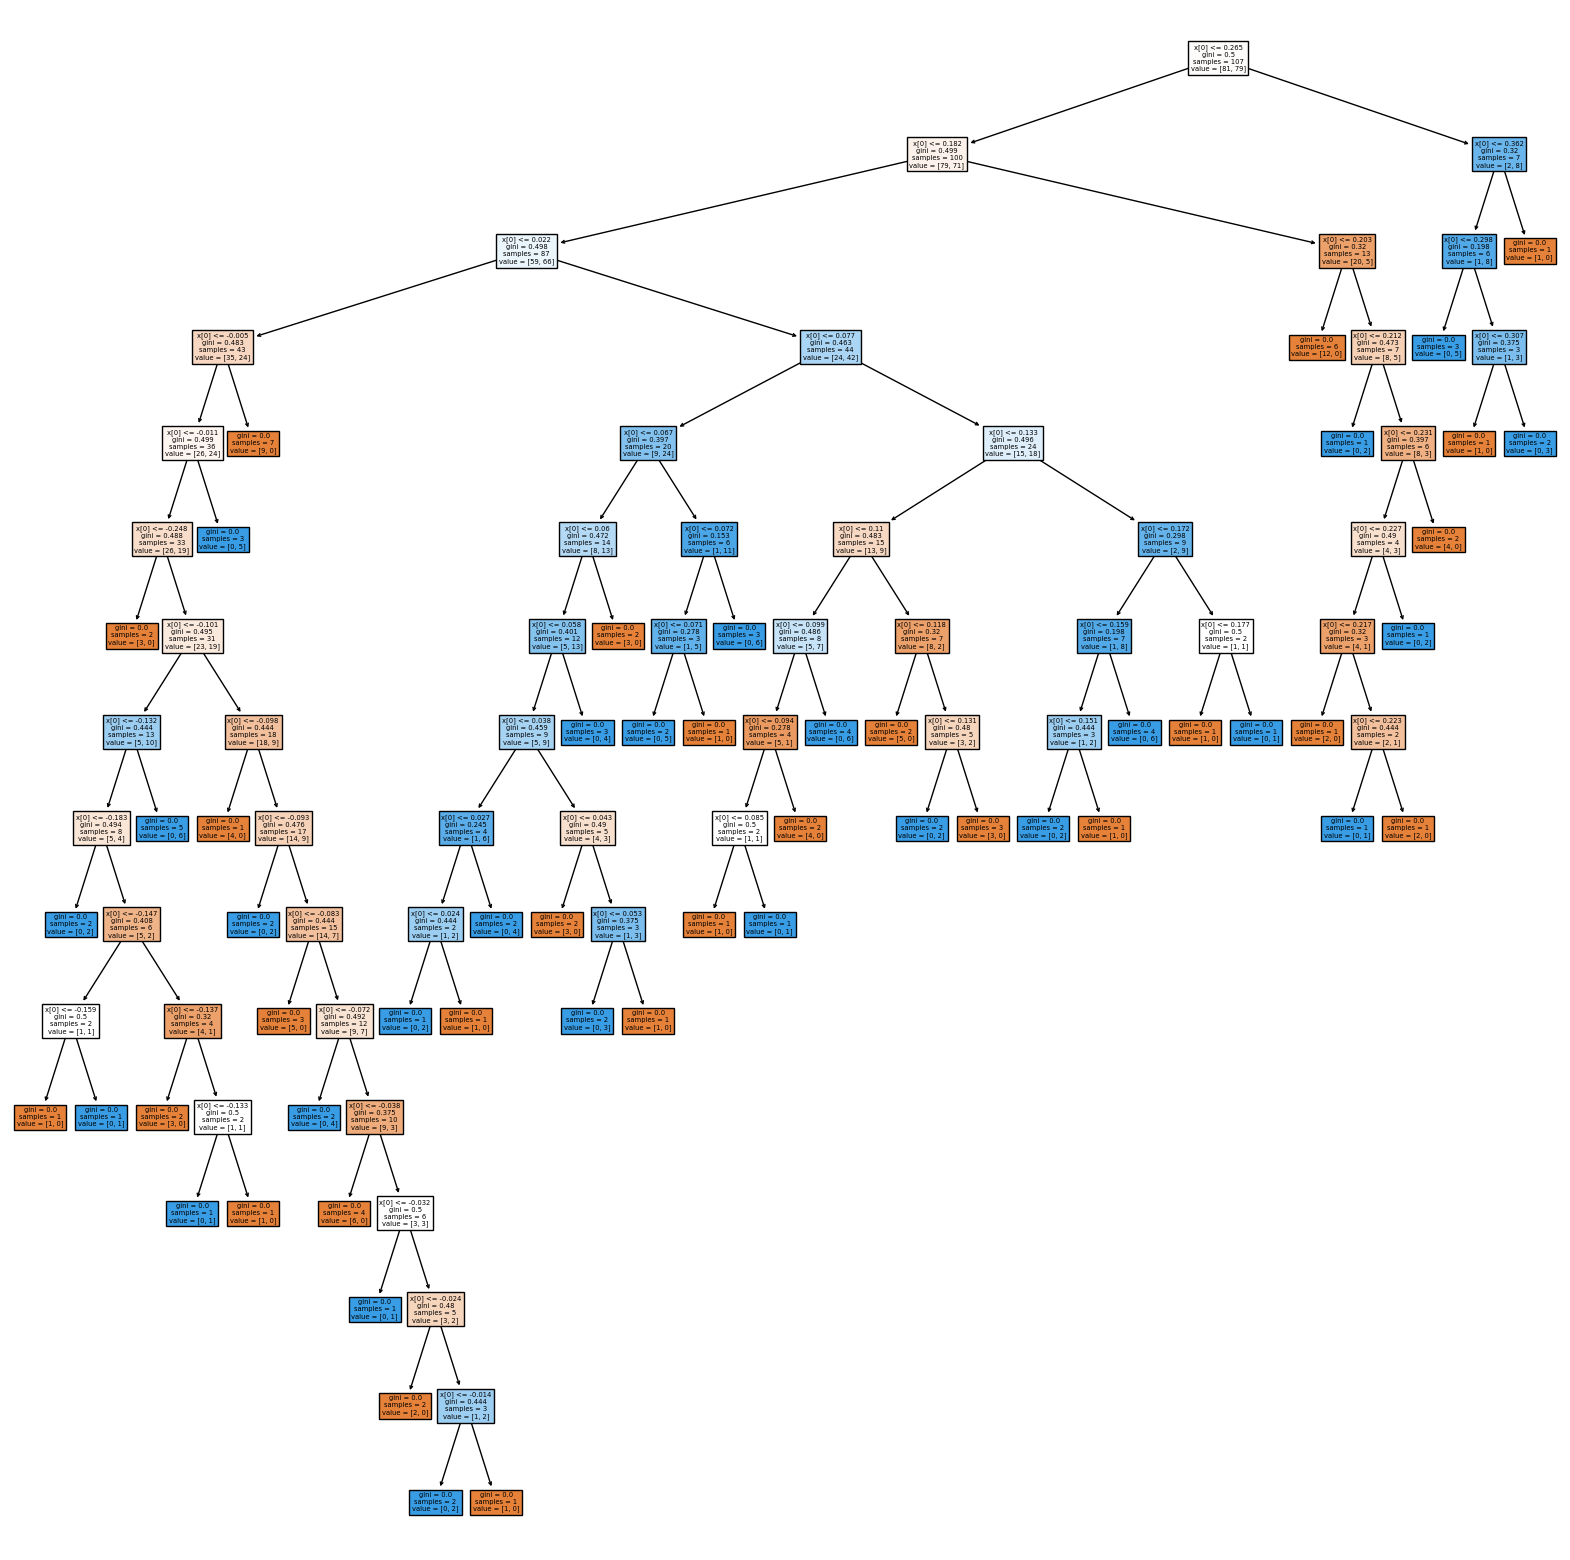

In [10]:
# print tree diagram
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
tree.plot_tree(rf_clf.estimators_[0], filled=True)
plt.show()

In [16]:
# predict from user input

def predict_sentiment():
    sentiment_score = float(input("Enter sentiment score: "))
    prediction = rf_clf.predict([[sentiment_score]])
    if prediction[0] == 1:
        print("Stock price will rise")
    else:
        print("Stock price will fall")

predict_sentiment()

Stock price will fall


c:\Users\elmat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
